In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Mock function to simulate Wilson lower bound tightening
def mock_lower_bound(shots, fidelity=0.9, decay=200):
    # Exponential approach to fidelity: lb = fidelity * (1 - exp(-shots/decay))
    return fidelity * (1 - np.exp(-shots/decay))

In [7]:
threshold = 0.90
shots_per_iter = 50
max_iters = 20

results = {}
for name in ['Clifford', 'Non-Clifford']:
    shots = np.arange(1, max_iters+1) * shots_per_iter
    # Use slightly different decay rates to distinguish the two curves
    decay = 200 if name=='Clifford' else 300
    lbs = [mock_lower_bound(s, decay=decay) for s in shots]
    results[name] = (shots, lbs)

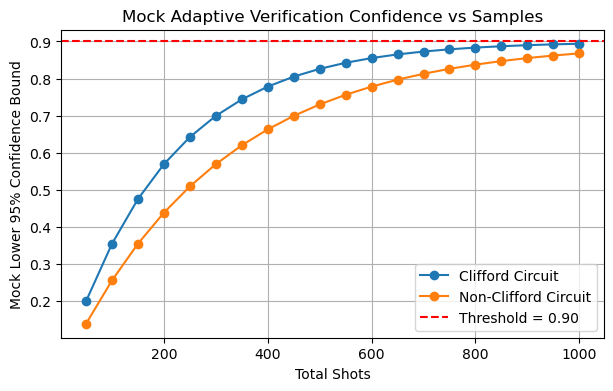

In [8]:
plt.figure(figsize=(7,4))
for name, (x, lb) in results.items():
    plt.plot(x, lb, marker='o', label=f'{name} Circuit')

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold = 0.90')
plt.xlabel('Total Shots')
plt.ylabel('Mock Lower 95% Confidence Bound')
plt.title('Mock Adaptive Verification Confidence vs Samples')
plt.legend()
plt.grid(True)

plt.savefig("adaptive_verification_plot.png", dpi=300)
plt.show()